In [16]:
import os
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [17]:
base_dir = r"data"  # Define your base directory
label = []       # Labels for each category
images_path = [] # Paths of all images
all_images = []  # Names of all images
img_label = []   # Labels corresponding to each image

for directory in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, directory)):
        label.append(directory)
        # Using glob to find all jpg, jpeg, and png files
        for img_path in glob.glob(os.path.join(base_dir, directory, '*.jpg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.jpeg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.png')):
            img_name = os.path.basename(img_path)
            all_images.append(img_name)
            images_path.append(img_path)
            img_label.append(directory)


In [18]:
img_shape = cv2.imread(images_path[0])

print(f"Labels : { label}")
print(f"Total Images : {len(all_images)}")
print(f" Images shape : {img_shape.shape}")

Labels : ['non-vehicles', 'vehicles']
Total Images : 17760
 Images shape : (64, 64, 3)


In [19]:
data =pd.DataFrame({'image':images_path,'label':img_label}) 
data

image         label
0         data\non-vehicles\extra1.png  non-vehicles
1        data\non-vehicles\extra10.png  non-vehicles
2       data\non-vehicles\extra100.png  non-vehicles
3      data\non-vehicles\extra1000.png  non-vehicles
4      data\non-vehicles\extra1001.png  non-vehicles
...                                ...           ...
17755     data\vehicles\right (95).png      vehicles
17756     data\vehicles\right (96).png      vehicles
17757     data\vehicles\right (97).png      vehicles
17758     data\vehicles\right (98).png      vehicles
17759     data\vehicles\right (99).png      vehicles

[17760 rows x 2 columns]

In [20]:
data = data.sample(frac=1).reset_index()
data.head()

index                            image         label
0  14330           data\vehicles\5828.png      vehicles
1   5560  data\non-vehicles\image1441.png  non-vehicles
2    982  data\non-vehicles\extra2141.png  non-vehicles
3   5105  data\non-vehicles\image1031.png  non-vehicles
4  10994           data\vehicles\2825.png      vehicles

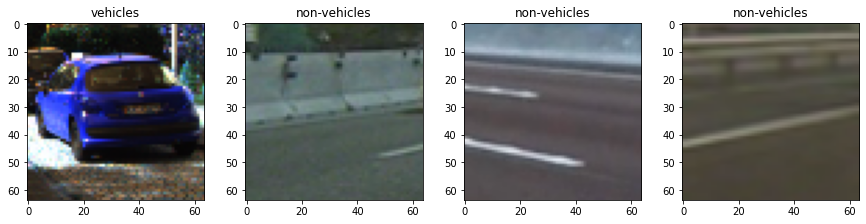

In [21]:
fig = plt.figure(figsize=(15,15))

for i in range(4):
    fig.add_subplot(4,4,i+1).set_title(data['label'][i])
    img = cv2.imread(data['image'][i])
    plt.imshow(img)
    
plt.show()

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17760 entries, 0 to 17759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17760 non-null  int64 
 1   image   17760 non-null  object
 2   label   17760 non-null  object
dtypes: int64(1), object(2)
memory usage: 416.4+ KB


In [23]:
data['label'].value_counts()

non-vehicles    8968
vehicles        8792
Name: label, dtype: int64

# As we can see the data is more or less equally distributed.

In [24]:
X = data.drop('label',axis=1)
X = data.drop('index',axis=1)
Y = data.label

In [25]:
X_train, X_final_test, y_train, y_final_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_final_test.shape)

(14208, 2)
(3552, 2)


In [26]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
print(X_train2.shape)
print(X_test2.shape)

(11366, 2)
(2842, 2)


In [27]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
training_set = train_datagen.flow_from_dataframe(
    dataframe = X_train2,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

validation_set = train_datagen.flow_from_dataframe(
    dataframe = X_train2,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

test_set = test_datagen.flow_from_dataframe(
    dataframe = X_test2,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Found 9093 validated image filenames belonging to 2 classes.
Found 2273 validated image filenames belonging to 2 classes.
Found 2842 validated image filenames belonging to 2 classes.


In [30]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 512, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [31]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["acc"])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [33]:
history = model.fit(training_set, epochs=10,validation_data = validation_set, callbacks=[early_stopping],batch_size=32)

Epoch 1/10


285/285 [==============================] - 164s 569ms/step - loss: 0.2230 - acc: 0.9108 - val_loss: 0.0633 - val_acc: 0.9842
Epoch 2/10
285/285 [==============================] - 43s 150ms/step - loss: 0.0718 - acc: 0.9756 - val_loss: 0.0476 - val_acc: 0.9881
Epoch 3/10
285/285 [==============================] - 43s 152ms/step - loss: 0.0651 - acc: 0.9786 - val_loss: 0.0452 - val_acc: 0.9859
Epoch 4/10
285/285 [==============================] - 2069s 7s/step - loss: 0.0593 - acc: 0.9828 - val_loss: 0.0420 - val_acc: 0.9890
Epoch 5/10
285/285 [==============================] - 47s 165ms/step - loss: 0.0511 - acc: 0.9821 - val_loss: 0.0376 - val_acc: 0.9894
Epoch 6/10
285/285 [==============================] - 44s 156ms/step - loss: 0.0387 - acc: 0.9892 - val_loss: 0.0141 - val_acc: 0.9956
Epoch 7/10
285/285 [==============================] - 43s 150ms/step - loss: 0.0314 - acc: 0.9897 - val_loss: 0.0369 - val_acc: 0.9872
Epoch 7: early stopping
